In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [39]:
import ipywidgets as widgets
from ipywidgets import interact

#### Things you may change in the experiment

N = 8
dT = 150 * 5 / 1200 # s/step
T = 5 # Switch RF on and off every 5 ms (i.e. on for 2.5 ms, off for 2.5 ms)

def LED_state(t):
    # must be 0 or 1 (or between but why)
    return 1

def RF_state(t):
    return ~(t % T < T/2)

def RF_freq(t):
    # returns how on resonance from 0 to 1
    return lorentzian(t, 150*T/2, 10.0)

#### Physics (only god may adjust)

def lorentzian(x, x0, gamma):
    return gamma**2 / ((x - x0)**2 + gamma**2)

def k5(t):
    return RF_freq(t) * RF_state(t) * 0.3 + 0.1


def update_plot(_k0, k1, k2, k3, k4):

    y0 = np.array([1, 0, 0])

    def k0(t):
        return LED_state(t) * _k0

    def dydt(t, y):
        return np.array([
            -k1 * y[0] + k0(t) * y[1] + k3 * (1 - y[0]) + k5(t) * y[2],
             k1 * y[0] - k0(t) * y[1] - k2 * y[1] - k4 * y[1],
             k4 * y[1] - k5(t) * y[2]
        ])

    y = solve_ivp(dydt, [0, 150*T], y0, t_eval=np.linspace(2, 150*T, 1200))
    plt.figure()
    plt.plot(y.t, y.y[1], label='y1')
    plt.legend()
    plt.show()

interact(update_plot, 
         _k0=widgets.FloatSlider(min=0, max=2, step=0.001, value=1, description='_k0'),
         k1=widgets.FloatSlider(min=0, max=1, step=0.001, value=0.1, description='k1'),
         k2=widgets.FloatSlider(min=0, max=1, step=0.001, value=0.1, description='k2'),
         k3=widgets.FloatSlider(min=0, max=0.01, step=0.0001, value=0.01, description='k3'),
         k4=widgets.FloatSlider(min=0, max=1, step=0.001, value=0.1, description='k4'))

# _k0 = 1 # ground -> excited
# k1 =  0.1 # excited -> ground
# k2 =  0.1  # excited -> dark
# k3 = 0.01 # dark -> ground (Note: assumes dark state is a bath, i.e. indep. of other things)
# k4 = 0.1  # excited -> intermediate singlet/triplet



interactive(children=(FloatSlider(value=1.0, description='_k0', max=2.0, step=0.001), FloatSlider(value=0.1, d…

<function __main__.update_plot(_k0, k1, k2, k3, k4)>

In [40]:
def poly_detrend(data, order=7):
    x = np.arange(data.shape[0])
    p = np.polyfit(x, data, order)
    return data - np.polyval(p, x)

def low_pass_detrend(data, cutoff=0.5):
    from scipy.signal import butter, filtfilt
    b, a = butter(1, cutoff)
    return filtfilt(b, a, data)

def high_pass_detrend(data, cutoff=0.1):
    from scipy.signal import butter, filtfilt
    b, a = butter(1, cutoff, btype='high')
    return filtfilt(b, a, data)

def smooth(data, window=5):
    return np.convolve(data, np.ones(window)/window, mode='same')


C:\Users\Gabi\AppData\Local\Temp\ipykernel_8468\1380025394.py:15: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  return ~(t % T < T/2)


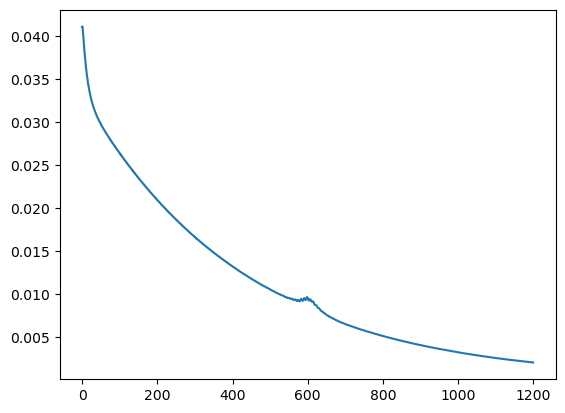

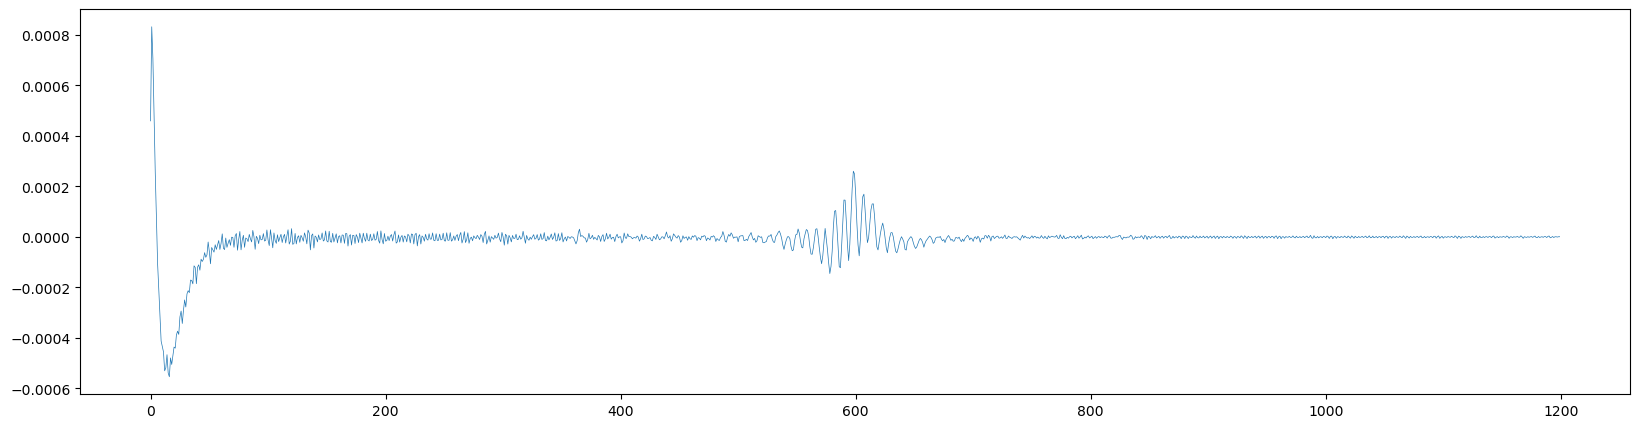

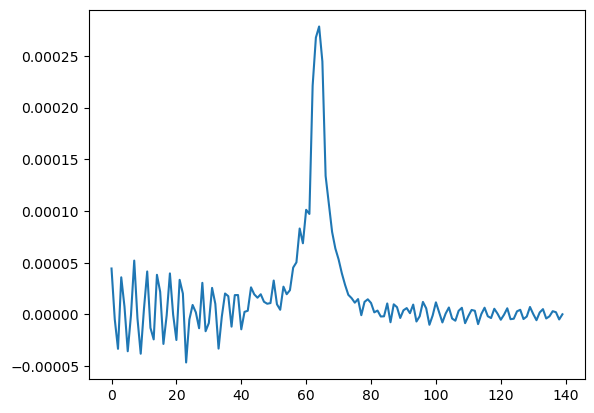

In [41]:
y0 = np.array([1, 0, 0])

_k0 = 1.00
k1 = 0.08
k2 = 0.11
k3 = 0.00
k4 = 0.65

def k0(t):
    return LED_state(t) * _k0

def dydt(t, y):
    return np.array([
        -k1 * y[0] + k0(t) * y[1] + k3 * (1 - y[0]) + k5(t) * y[2],
            k1 * y[0] - k0(t) * y[1] - k2 * y[1] - k4 * y[1],
            k4 * y[1] - k5(t) * y[2]
    ])

y = solve_ivp(dydt, [0, 150*T], y0, t_eval=np.linspace(2, 150*T, 1200))
t = y.t
PL = y.y[1]

plt.figure()
plt.plot(PL)

plt.figure(figsize=(20, 5))
plt.plot(high_pass_detrend(PL, cutoff=0.05), linewidth=0.5)

baseline = 100

detrendPL = (high_pass_detrend(PL, cutoff=0.05) + baseline).reshape(-1, int(N))
skip = 10
smooth = lambda x: x # low_pass_detrend(x, 0.1)
plt.figure()
plt.plot(smooth(detrendPL[skip:, -1] / detrendPL[skip:, detrendPL.shape[1]//2-1] - 1) * baseline)